# Session analysis

In [1]:
import pandas as pd
import numpy as np
import sys
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
# setting path
sys.path.append('..')

from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
import glob, os


In [2]:
import matplotlib
matplotlib.use('Agg')

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [3]:
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data, read_event_data
import pickle

In [4]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
vid_dir = '../data/videos/'
output_path = '../output/opt_flow/'
Path(output_path).mkdir(parents=True, exist_ok=True)

onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]
input_path = data_dir + onlyfiles[0] # pick a random file
input_postfix = onlyfiles[0].rsplit('adadrive-',1)[1].split('.dats',1)[0]
print(f"input_path {input_path}")
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
with open(input_path, 'rb') as handle:
    rns_data = pickle.load(handle)
for key in rns_data.keys():
    rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

event_df = read_event_data(rns_data)
event_df['trial_damage'] = event_df.damage.diff().fillna(0)
event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
percent_missing = event_df.notnull().sum() / len(event_df)

event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                      value=[1, 2, None])
print(f"Received trial data for participant ID {event_df.iloc[0].ppid}, session {event_df.iloc[0].session}")

input_path ../data/09_14_2022_13_17_39-Exp_adadrive-Sbj_20-Ssn_3.dats.pkl
Received trial data for participant ID 20, session 3


# 2. Eye Tracking Processing

In [5]:
vid_path = glob.glob(f"{vid_dir}*{input_postfix}*.mp4")[0]
time_csv_path = glob.glob(f"{vid_dir}*{input_postfix}*.csv")[0]
time_csv = pd.read_csv(time_csv_path) # maps video frame information to lsl timestamps

## Raw eye tracking data

In [6]:
et_df = pd.DataFrame(rns_data['Unity_ViveSREyeTracking'][0], columns=rns_data['Unity_ViveSREyeTracking'][1],
                  index=rns_data['Unity_ViveSREyeTracking'][2]['ChannelNames']).T
et_df = et_df.reset_index().rename(columns={'index': 'timestamp'})

In [7]:
et_df.head()

,timestamp,L Pupil Diameter,R Pupil Diameter,L Openness,R Openness,L Gaze Direction X,L Gaze Direction Y,L Gaze Direction Z,R Gaze Direction X,R Gaze Direction Y,R Gaze Direction Z,L Gaze Origin X,L Gaze Origin Y,L Gaze Origin Z,R Gaze Origin X,R Gaze Origin Y,R Gaze Origin Z
0,6098.734691,4.443146,4.003098,1.0,1.0,0.039566,0.066422,0.996994,0.053345,0.040771,0.997742,35.238373,2.697052,-33.992493,-30.429001,1.569672,-33.198151
1,6098.743053,4.446487,4.002975,1.0,1.0,0.039673,0.068604,0.996841,0.053116,0.040390,0.997757,35.238052,2.683060,-33.981293,-30.429642,1.565643,-33.195541
2,6098.751385,4.444351,4.002823,1.0,1.0,0.039566,0.066696,0.996979,0.053040,0.040146,0.997772,35.236694,2.681610,-33.960739,-30.430130,1.565033,-33.195541
3,6098.759716,4.428314,3.996719,1.0,1.0,0.038010,0.067200,0.997009,0.052582,0.039124,0.997849,35.234192,2.660431,-33.910706,-30.430130,1.564743,-33.195541
4,6098.768047,4.446533,3.980560,1.0,1.0,0.038269,0.066833,0.997025,0.051117,0.038696,0.997940,35.232819,2.654617,-33.905121,-30.430130,1.564682,-33.195541


## Segment level ET data

In [ ]:
post_processed_event_df = process_session_eye(rns_data, event_df,detect_blink=True,plot_frequency=20, plot_eye_snippet=40)

In [24]:
post_processed_event_df.head()

,trial_start_time,trial_end_time,data_type,message_no,dataflow_publish_time,incorrect_original_chunk_timestamps,chunk_dataflow_publish_time,chunk,block_condition,incorrect_original_timestamps,...,REMODNAV_first_onset.Smooth Pursuit,REMODNAV_mean_duration.Fixation,REMODNAV_mean_duration.PSO,REMODNAV_mean_duration.Saccade,REMODNAV_mean_duration.Smooth Pursuit,REMODNAV_class_onsets,Left Pupil Diameter,Right Pupil Diameter,Left Evoked Pupil Diameter,Right Evoked Pupil Diameter
0,6098.731862,6166.304443,Unity.TrialInfo,992.0,2022-09-14 17:18:47.442000,6165.684285,2022-09-14 17:18:47.485000,South to North,practice,6165.683694,...,6099.034640,0.163374,0.022543,0.072423,0.311272,"[[6098.7346907609335, Fixation], [6098.9346674...",4.352637,3.900177,NaN,NaN
1,6166.305443,6182.522417,Unity.TrialInfo,1235.0,2022-09-14 17:19:04.033000,6182.628495,2022-09-14 17:19:04.041000,South to North,practice,6182.628487,...,6166.828610,0.107213,0.023131,0.050604,0.389046,"[[6166.3123779509015, Fixation], [6166.3956398...",4.628136,3.863114,-0.582395,-0.398012
2,6182.523417,6194.576583,Unity.TrialInfo,1407.0,2022-09-14 17:19:15.953000,6195.530659,2022-09-14 17:19:16.071000,South to West,practice,6195.530747,...,6182.766937,0.102558,0.022209,0.049683,0.327979,"[[6182.525428097467, Fixation], [6182.69198450...",3.720313,3.100665,-0.910147,-0.752988
3,6194.577583,6208.231816,Unity.TrialInfo,1604.0,2022-09-14 17:19:29.555000,6208.981013,2022-09-14 17:19:29.786000,East to North,practice,6208.981120,...,6195.217883,0.162794,0.023797,0.059164,0.304205,"[[6194.584908550729, Fixation], [6194.68485132...",3.411757,2.843763,0.001862,0.072192
4,6208.232816,6226.050794,Unity.TrialInfo,1864.0,2022-09-14 17:19:47.508000,6225.001275,2022-09-14 17:19:47.747000,South to West,practice,6225.001383,...,6209.210641,0.153548,0.020229,0.059065,0.295160,"[[6208.236098033303, Fixation], [6208.44433233...",3.356291,2.855237,0.064181,0.037339


# 3. Overlay eye tracking data onto the original video and optionally write the output

This is the primary chunk of code that reads from `time_start` in seconds to `max_frames` 

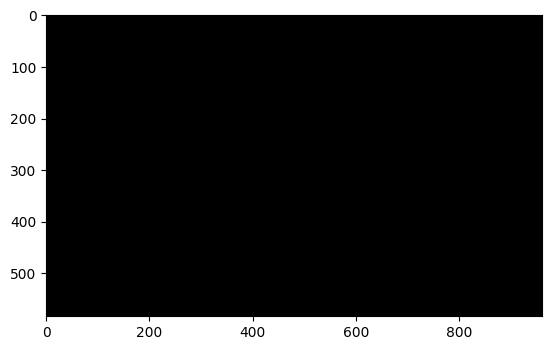

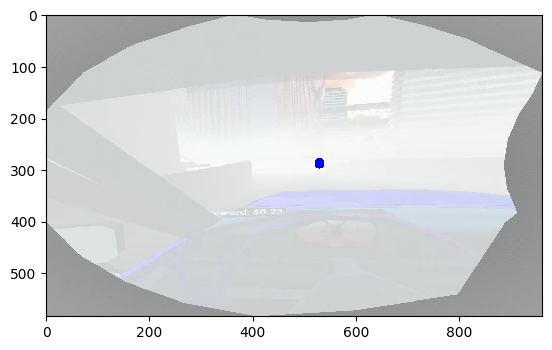

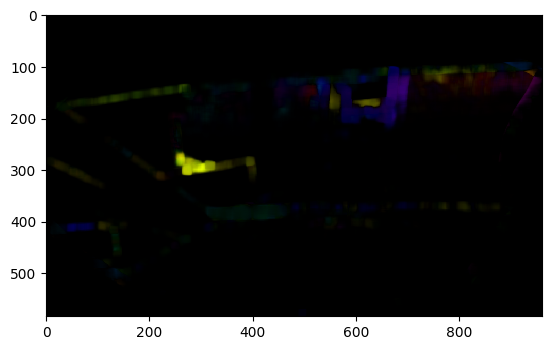

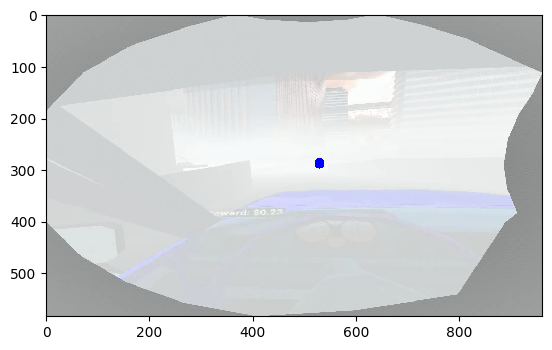

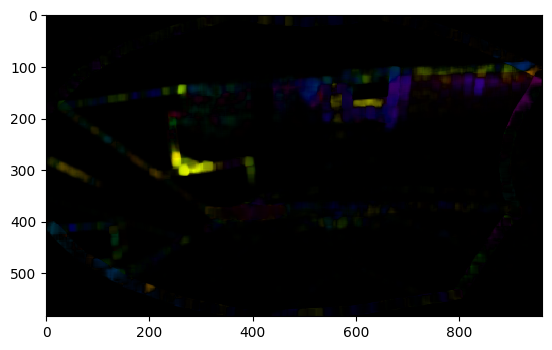

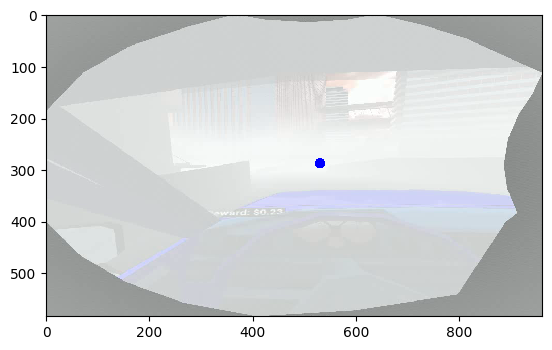

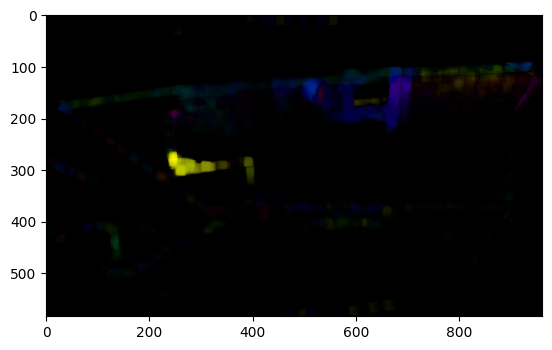

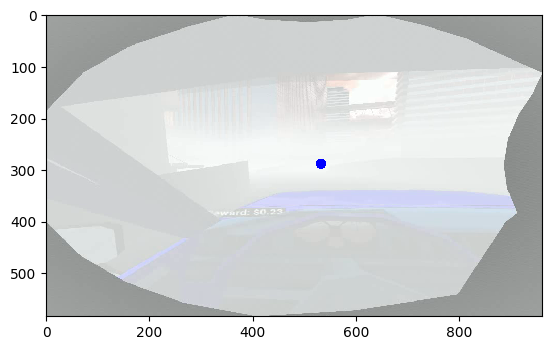

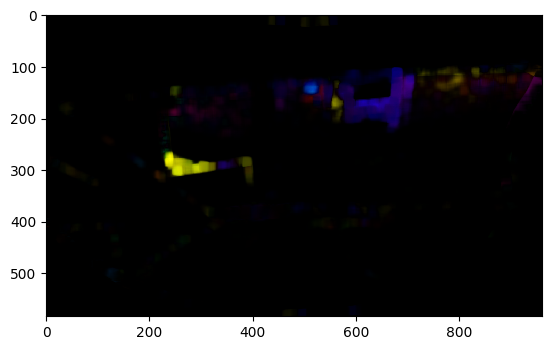

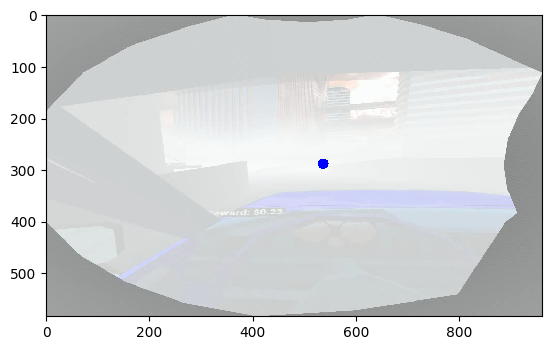

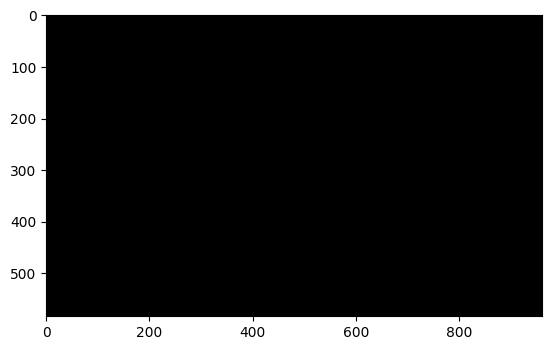

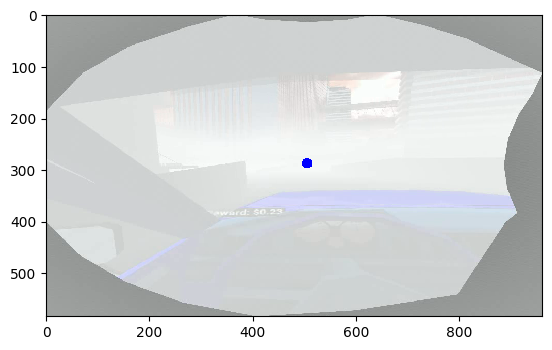

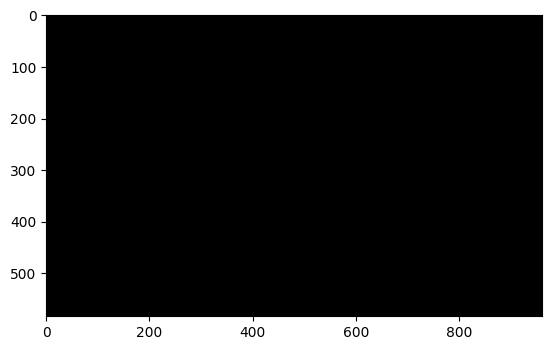

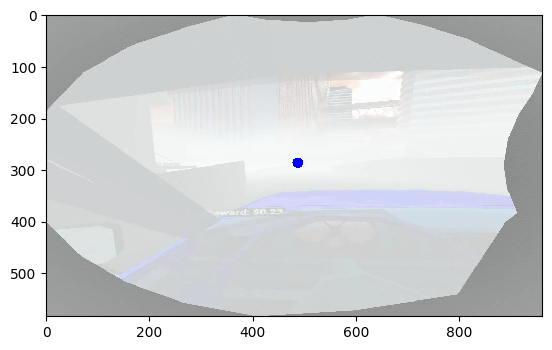

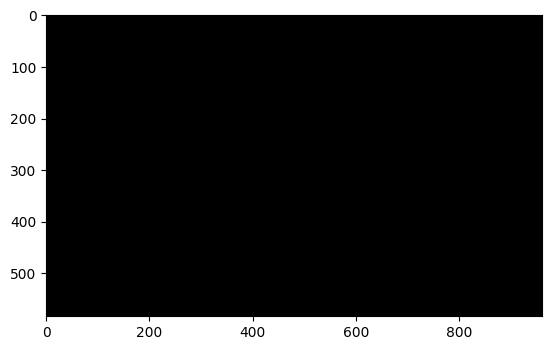

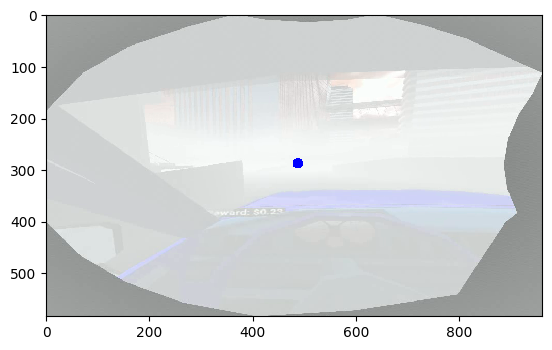

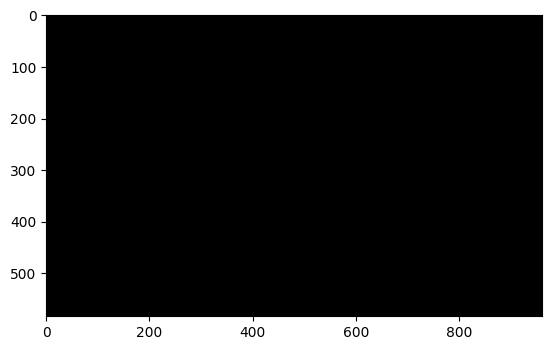

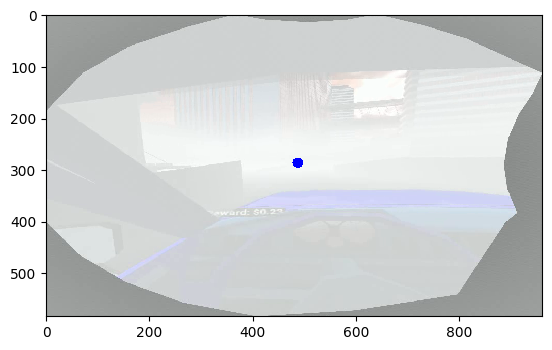

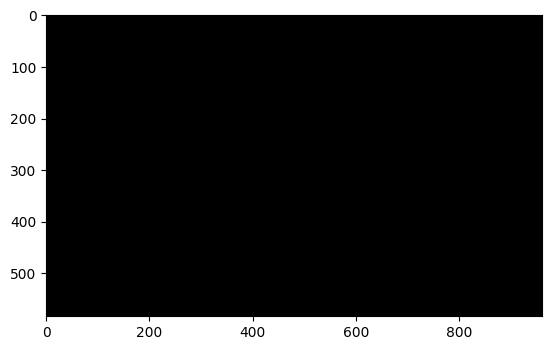

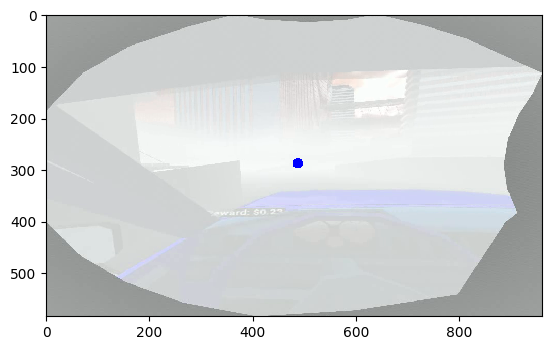

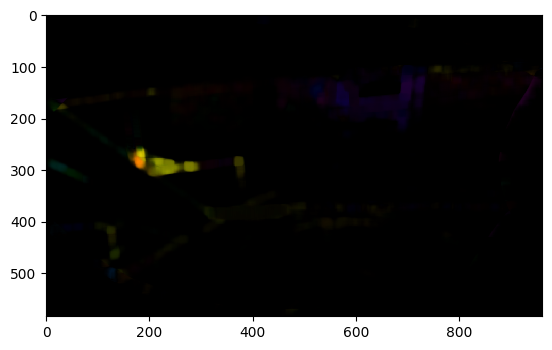

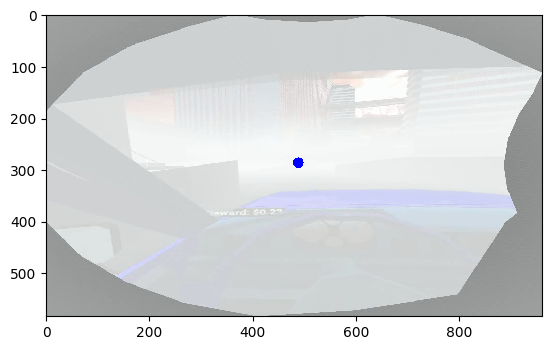

In [10]:
%matplotlib inline 

max_frames = 10 # total number of frames to plot, set to 0 to loop through all frames
save_et_video = False # this writes a eye tracking coordinate over video to the output directory
save_opt_video = False # this writes optical flow representations
show_inline_images = True # shows figures inline in this cell output. 
                          # could crash the kernel if this is done for the entire video so set to false if you're
                          # rendering video

cap = cv2.VideoCapture(cv2.samples.findFile(f"{vid_path}"))
width = cap.get(3)
height = cap.get(4)
fps = cap.get(5)


if save_et_video:
    et_result = cv2.VideoWriter(f"{output_path}{input_postfix}_eye_tracking.avi",
                             cv2.VideoWriter_fourcc(*'MJPG'),
                             fps, (int(cap.get(3)), int(cap.get(4))))
if save_opt_video:
    opt_result = cv2.VideoWriter(f"{output_path}{input_postfix}_opt_flow.avi",
                             cv2.VideoWriter_fourcc(*'MJPG'),
                             cap.get(5), (int(cap.get(3)), int(cap.get(4))))
time_start = 300 # in seconds
frame_idx = int(time_start*fps) # 0 is the start of video but this frame number can be whatever
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx-1)

# get the first frame to start calculating the optical flow
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255

local_frame_no = 0
while(1):
    timestamp = time_csv.iloc[frame_idx].lsl_timestamp
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
        
    # optical flow information
    next_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # get the magnitude and angle, this is the most relevant optical flow data
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # convert mag and ang into visualizable color information (color intensity and hue specifically)
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # eye tracking overlay
    df_sort = et_df.iloc[(et_df['timestamp'] - timestamp).abs().argsort()[0]]
    eye_x = (width-(df_sort['L Gaze Direction X'] * width))/2
    eye_y = (height-(df_sort['L Gaze Direction Y'] * height))/2 # eye_x and eye_y are in video coordinates
    frame = cv2.circle(frame, (int(eye_x), int(eye_y)), 10, (0, 0, 255),
                       thickness=-1)
    
    if show_inline_images:
        plt.imshow(bgr, interpolation='nearest')
        plt.show()
        plt.imshow(frame, interpolation='nearest')
        plt.show()
        key = cv2.waitKey(int(1/fps*1000)) #pauses for some time seconds before fetching next image
    if max_frames > 0 and local_frame_no >= max_frames:
        break
    if save_et_video:
        et_result.write(frame)
    if save_opt_video:
        opt_result.write(bgr)
    prvs = next_frame
    frame_idx += 1
    local_frame_no += 1
cv2.destroyAllWindows()
if save_et_video:
    et_result.release()
if save_opt_video:
    opt_result.release()

In [19]:
print(f"height and width of optical flow vector magnitudes for the last frame processed {mag.shape}") # will be video shape
print(f"height and width of optical flow vector magnitudes for the last frame processed {ang.shape}") # will be video shape
print(f"position of foveated pixel in y and x {eye_y, eye_x}")

height and width of optical flow vector magnitudes for the last frame processed (584, 962)
height and width of optical flow vector magnitudes for the last frame processed (584, 962)
position of foveated pixel in y and x (287.66473388671875, 489.01470947265625)


# 5. EEG

In [8]:
post_processed_event_df, epochs, events, event_dict, info, reject_log, ica = process_session_eeg(rns_data, post_processed_event_df,
                                                                    event_column='spoken_difficulty_encoded', run_autoreject=True, run_ica=True,
                                                                                                normalize_pow_freq = False)

Creating RawArray with float64 data, n_channels=89, n_times=3399947
    Range : 0 ... 3399946 =      0.000 ...  1660.130 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.8s finished


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Fitting ICA took 45.4s.
Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 411 original time points ...
0 bad epochs dropped
Dropped 6 epochs: 11, 17, 23, 25, 29, 33
